In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete32HD98/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete32HD98/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path=PosixGPath('/tmp/tmpig8oqebltfds'),
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao a

In [4]:
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [5]:
nombres_clases = metadatos.features['label'].names

In [6]:
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
#Normalizar los() datos (pasar de 0-255 a 0-1)
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #aqui lo pasa de 0-255 a 0-1
  return imagenes, etiquetas

#Normalizar los datos de entrenamiento y pruebbas con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregar a cache ( usar memoria en lugar de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

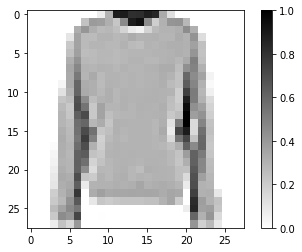

In [12]:
#Mostrar una imagen de los datos de prueba de momento mostremos la primera
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28,28)) #Redimensionar, cosa de tensores, lo veremos despues

import matplotlib.pyplot as plt

#Dibujar
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

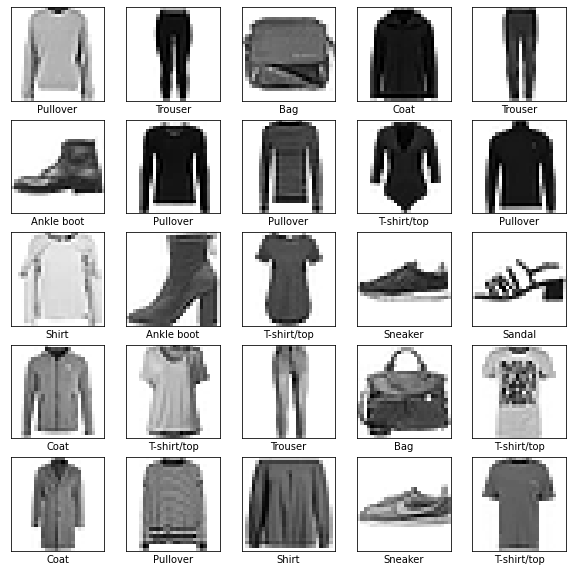

In [13]:
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid()
  plt.imshow(imagen,cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [14]:
#Crear modelo

modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)), #1 -blanco y negro
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)#Para redes de clasificacion
])

In [15]:
#Compilar el modelo

modelo.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [16]:
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

In [17]:
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [18]:
TAMANI_LOTE = 32

datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANI_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANI_LOTE)

In [19]:
import math

#Entrenar
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANI_LOTE))

Epoch 1/5
1875/1875 [==============================] - 11s 3ms/step - loss: 0.5162 - accuracy: 0.8178
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3818 - accuracy: 0.8626
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3492 - accuracy: 0.8715
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3252 - accuracy: 0.8807
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3113 - accuracy: 0.8853


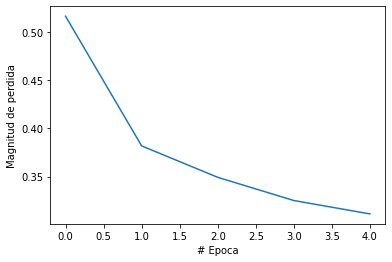

In [20]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de perdida")
plt.plot(historial.history["loss"])

1/1 [==============================] - 0s 19ms/step


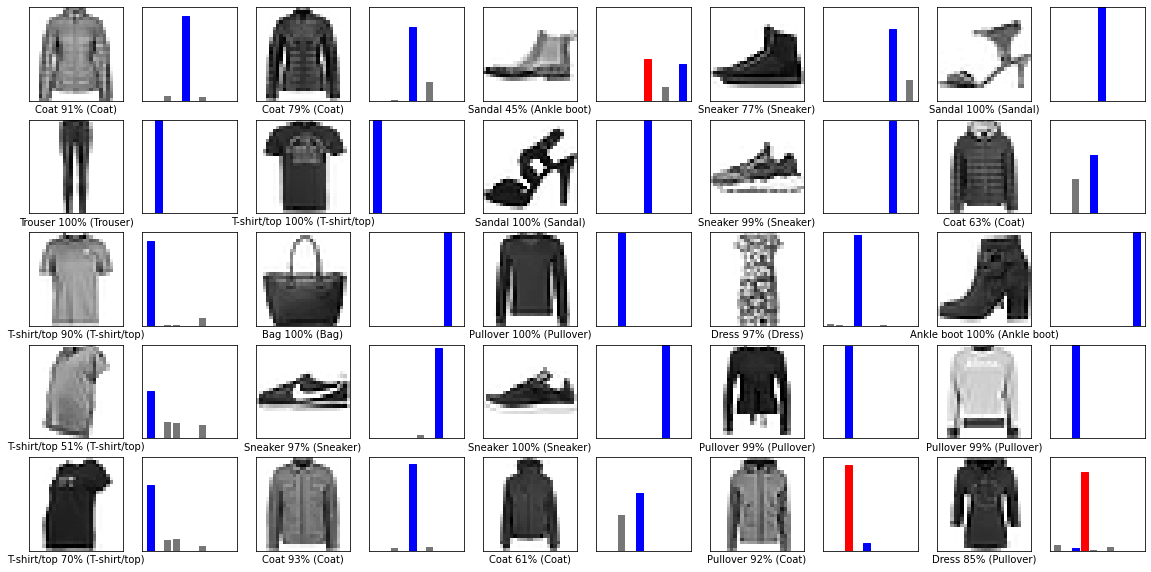

In [26]:
import numpy as np

for imagenes_prueba, etiqueta_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiqueta_prueba = etiqueta_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue' #Si le atino
  else: 
    color = 'red' #Oops, no le atino
  
  plt.xlabel("{} {:2.0f}% ({})".format(
      nombres_clases[etiqueta_prediccion],
      100*np.max(arr_predicciones),
      nombres_clases[etiqueta_real],
      color=color
  ))

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color='#777777')
  plt.ylim([0,1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')

filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas,2*filas))

for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i,predicciones,etiqueta_prueba,imagenes_prueba)
  plt.subplot(filas,2*columnas,2*i+2)
  graficar_valor_arreglo(i,predicciones,etiqueta_prueba)




In [28]:
#Tomar cualquier indice del set de pruebas para ver su prediccion
imagen = imagenes_prueba[10]
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: "+nombres_clases[np.argmax(prediccion[0])])

1/1 [==============================] - 0s 31ms/step
Prediccion: T-shirt/top


In [29]:
#Exportacion del modelo

modelo.save('modelo_exportado.h5')

In [ ]:
#Instalar tensorflow
!pip install tensorflowjs

In [38]:
#Convertir el archivo h5 a formato de tensorflowjs

!mkdir tfjs_target_dir
!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

mkdir: cannot create directory ‘tfjs_target_dir’: File exists
2023-01-25 18:40:41.067448: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-25 18:40:41.067665: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-25 18:40:41.067697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
